In [1]:
!pip install -q torch_snippets
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 13.65 KiB | 3.41 MiB/s, done.
/kaggle/working/ssd-utils


In [20]:
from torch_snippets import *
data_root = '/kaggle/input/open-images-bus-trucks'
image_root = f'{data_root}/images/images'
df_raw = df = pd.read_csv(f'{data_root}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [21]:
image_root

'/kaggle/input/open-images-bus-trucks/images/images'

In [22]:
label2target = {l:t+1 for t, l in enumerate(df_raw['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l, t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
import collections, os, torch, glob
from PIL import Image
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                  std=[1.0/0.229, 1.0/0.224, 1.0/0.225])

In [24]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

In [25]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=image_root):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir + '/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f"{len(self)} items loaded.")
    
    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR)) / 255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin', 'YMin', 'XMax', 'YMax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        return img, boxes, labels
    
    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device) / 300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels

    def __len__(self):
        return len(self.image_infos)

In [26]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(df.ImageID.unique(), test_size=0.1)
train_df, valid_df = df[df['ImageID'].isin(train_ids)], df[df['ImageID'].isin(valid_ids)]

len(train_df), len(valid_df)

(21662, 2400)

In [27]:
train_ds = OpenDataset(train_df)
test_ds = OpenDataset(valid_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

[11/08/23 06:19:03] INFO     13702 items loaded.                                                                                                     ]8;id=576253;file:///tmp/ipykernel_32/187305052.py:8\187305052.py]8;;\:]8;id=527634;file:///tmp/ipykernel_32/187305052.py:8#__init__:8\__init__:8]8;;\

                    INFO     1523 items loaded.                                                                                                      ]8;id=398416;file:///tmp/ipykernel_32/187305052.py:8\187305052.py]8;;\:]8;id=267457;file:///tmp/ipykernel_32/187305052.py:8#__init__:8\__init__:8]8;;\

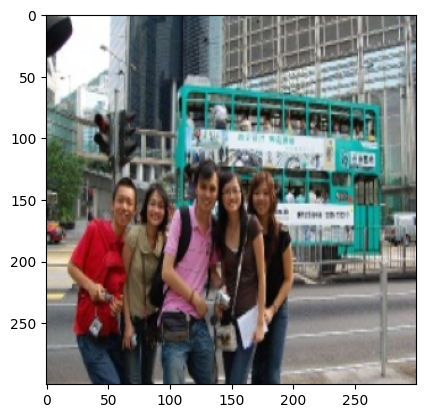

In [30]:
plt.imshow(train_ds[0][0])

In [35]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [36]:
from model import SSD300, MultiBoxLoss
from detect import *

In [37]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [38]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), end='\r')
    
    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 3.000  val_loss: 1.638  (1660.39s - 0.00s remaining)))))

In [40]:
image_paths = Glob(f'{data_root}/images/images')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

[[2, 31, 255, 156]]
['Bus @ 1.00']

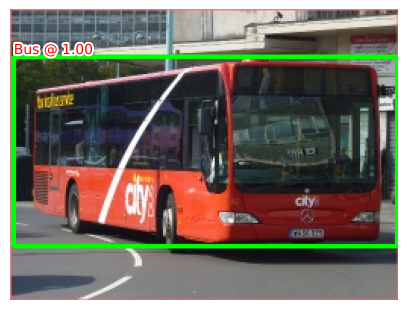

[[117, 91, 211, 135]]
['Truck @ 0.98']

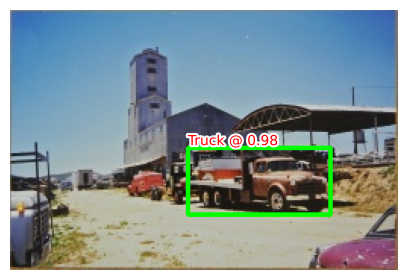

[[0, 0, 256, 192]]
['background @ 0.00']

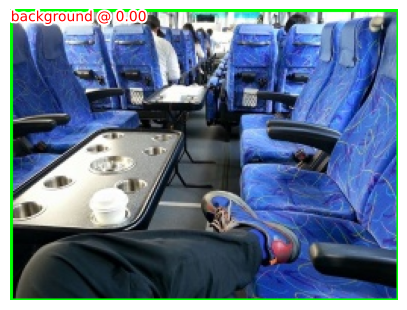

[[35, 55, 247, 121]]
['Bus @ 1.00']

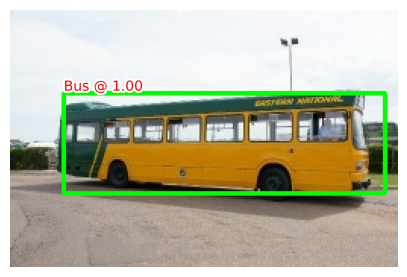

[[78, 38, 176, 118]]
['Bus @ 1.00']

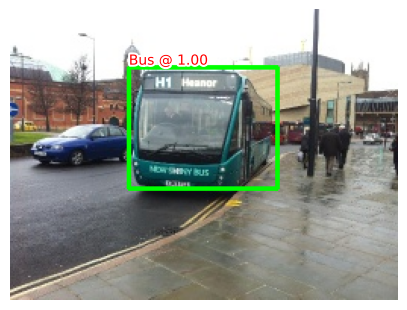

In [42]:
for _ in range(5):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5, top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f"{l} @ {s:.2f}" for l, s in zip(labels, scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)